In [1]:
import numpy as np

from petsc4py import PETSc
from mpi4py import MPI

import dolfinx, ufl
print(f"DOLFINx version: {dolfinx.__version__}")
print(f"UFL version: {ufl.__version__}")

from dolfinx import fem,mesh,plot
import dolfinx.fem.petsc

DOLFINx version: 0.7.2
UFL version: 2023.2.0


In [2]:
# Geometry
L = 5.0
H = 0.5

In [3]:
# Mesh
Nx = 50
Ny =  5
domain = mesh.create_rectangle(MPI.COMM_WORLD,[[0.0, 0.0],[L,H]],[Nx,Ny],mesh.CellType.quadrilateral)
tdim = domain.topology.dim
V = fem.FunctionSpace(domain,("Lagrange",1,(tdim,)))

In [4]:
# Dirichlet boundary conditions
def clamped_boundary(x):
    return np.isclose(x[0],0.0)

fdim = domain.topology.dim-1
clamped_facets = mesh.locate_entities_boundary(domain,fdim,clamped_boundary)
uD = np.array([0.0,0.0],dtype=PETSc.ScalarType)
bc = fem.dirichletbc(uD,fem.locate_dofs_topological(V,fdim,clamped_facets),V)

In [5]:
# Neumann boundary conditions
def traction_boundary(x):
    return np.isclose(x[0],L)

traction_facets = mesh.locate_entities(domain,fdim,traction_boundary)
traction_facets_tag = mesh.meshtags(domain,fdim,traction_facets,np.full_like(traction_facets,1))
ds = ufl.Measure("ds",domain=domain,subdomain_data=traction_facets_tag)

T = fem.Constant(domain,np.array([0.1e-3,-1.0e-3],dtype=PETSc.ScalarType))

## Model-based solution

In [6]:
# Constitutive parameters
E = 100.0
nu = 0.3
lam = nu*E/(1.0+nu)/(1.0-2*nu)
mu2 = E/(1.0+nu)

# Constitutive model (as expressions)
def epsilon(u):
    return ufl.sym(ufl.grad(u))
def sigma_hooke(e):
    return lam*ufl.tr(e)*ufl.Identity(tdim)+mu2*e

In [7]:
# Weak form
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.inner(sigma_hooke(epsilon(u)),epsilon(v))*ufl.dx
b = ufl.dot(T,v)*ds

In [8]:
# Solve the problem
std_problem = fem.petsc.LinearProblem(a,b,bcs=[bc],petsc_options={"ksp_type": "preonly","pc_type": "lu"})
std_uh = std_problem.solve()

In [11]:
# Compute stress
Sdev = sigma_hooke(epsilon(std_uh)) - 1./3 * ufl.tr(sigma_hooke(epsilon(std_uh))) * ufl.Identity(tdim)
Svm = ufl.sqrt(3./2 * ufl.inner(Sdev,Sdev))

V_vm = fem.FunctionSpace(domain, ("DG", 0))
stress_expr = fem.Expression(Svm, V_vm.element.interpolation_points())
stresses = fem.Function(V_vm)
stresses.interpolate(stress_expr)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



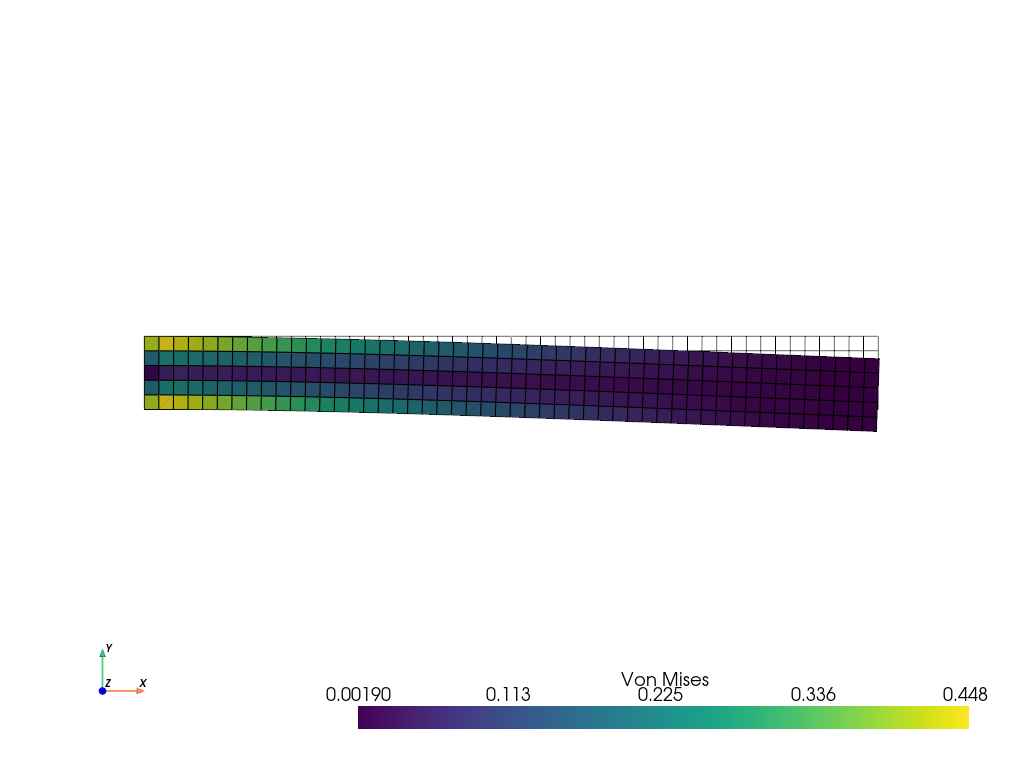

In [12]:
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(std_uh)] = std_uh.x.array.reshape((geometry.shape[0], 2))
grid["u"] = values
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.0)
warped.cell_data["Von Mises"] = stresses.vector.array
warped.set_active_scalars("Von Mises")
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
p.camera_position = 'xy'
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("stresses.png")

In [13]:
# Evaluate all strains and stresses
Sh = fem.FunctionSpace(domain,("DG",1,(tdim,tdim)))
eps_all = fem.Function(Sh)
eps_all.interpolate(fem.Expression(epsilon(std_uh),Sh.element.interpolation_points()))
print(eps_all.x.array.reshape((-1,tdim,tdim)))
sig_all = fem.Function(Sh)
sig_all.interpolate(fem.Expression(sigma_hooke(epsilon(std_uh)),Sh.element.interpolation_points()))
print(sig_all.x.array.reshape((-1,tdim,tdim)))

[[[-5.60939144e-03 -1.79383995e-03]
  [-1.79383995e-03  0.00000000e+00]]

 [[-2.88375725e-03 -7.78408521e-04]
  [-7.78408521e-04  0.00000000e+00]]

 [[-5.60939144e-03 -4.31022856e-04]
  [-4.31022856e-04  2.03086285e-03]]

 ...

 [[ 1.32825270e-05 -9.56385441e-06]
  [-9.56385441e-06 -1.30556151e-05]]

 [[ 9.67712009e-06 -6.21113168e-06]
  [-6.21113168e-06 -1.61556536e-05]]

 [[ 1.32825270e-05 -7.76115093e-06]
  [-7.76115093e-06 -1.61556536e-05]]]
[[[-7.55110386e-01 -1.37987688e-01]
  [-1.37987688e-01 -3.23618737e-01]]

 [[-3.88198092e-01 -5.98775786e-02]
  [-5.98775786e-02 -1.66370611e-01]]

 [[-6.37945221e-01 -3.31556043e-02]
  [-3.31556043e-02 -5.02333527e-02]]

 ...

 [[ 1.03482392e-03 -7.35681108e-04]
  [-7.35681108e-04 -9.91187017e-04]]

 [[ 3.70632302e-04 -4.77779360e-04]
  [-4.77779360e-04 -1.61650414e-03]]

 [[ 8.55975544e-04 -5.97011610e-04]
  [-5.97011610e-04 -1.40849989e-03]]]


## DD solution

In [14]:
# Construct database from previous simulation
DB_ref = np.concatenate((eps_all.x.array.reshape((-1,tdim*tdim)),sig_all.x.array.reshape((-1,tdim*tdim))),axis=1)
print(DB_ref.shape)

(1000, 8)


In [15]:
# Define metric
Edd = 100.0
nudd = 0.25
C11 = (1-nudd)*Edd/(1+nudd)/(1-2*nudd)
C12 = nudd*Edd/(1+nudd)/(1-2*nudd)
C44 = 0.5*Edd/(1+nudd)
C = ufl.as_matrix([[C11,C12,0],[C12,C11,0],[0,0,C44]])

In [17]:
# Construct kd-tree
import scipy.linalg as sla
CC = sla.sqrtm([[C11,C12,0],[C12,C11,0],[0,0,C44]])
CCinv = sla.inv(CC)
def all2Voigt(e,s):
    return np.concatenate((np.concatenate((e.reshape((-1,tdim*tdim))[:,[0,3]],2*e.reshape((-1,tdim*tdim))[:,[1]]),axis=1)@CC,  \
                           np.concatenate((s.reshape((-1,tdim*tdim))[:,[0,3]],s.reshape((-1,tdim*tdim))[:,[1]]),axis=1)@CCinv),\
                          axis=1)

from sklearn.neighbors import KDTree
tree = KDTree(all2Voigt(DB_ref[:,:4],DB_ref[:,4:]))

In [19]:
# use Voigt notation
def strain2voigt(e):
    return ufl.as_vector([e[0,0],e[1,1],e[0,1]+e[1,0]])
def voigt2stress(s):
    return ufl.as_tensor([[s[0],s[2]],[s[2],s[1]]])

In [20]:
# define bilinear form associated to metric
u_dd = ufl.TrialFunction(V)
v_dd = ufl.TestFunction(V)
a_dd = ufl.inner(voigt2stress(C*strain2voigt(epsilon(u_dd))),epsilon(v_dd))*ufl.dx

# generate associated matrix
bilinear_form_dd = fem.form(a)
A_dd = fem.petsc.assemble_matrix(bilinear_form_dd,bcs=[bc])
A_dd.assemble()
print(A_dd.getValues(range(A_dd.getSize()[0]),range(A_dd.getSize()[1])))

[[  1.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           1.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 115.38461538  -4.80769231
  -38.46153846]
 [  0.           0.           0.         ...  -4.80769231  57.69230769
   24.03846154]
 [  0.           0.           0.         ... -38.46153846  24.03846154
   57.69230769]]


In [21]:
# create linear solver
solver_dd = PETSc.KSP().create(domain.comm)
solver_dd.setOperators(A_dd)
solver_dd.setType(PETSc.KSP.Type.PREONLY)
solver_dd.getPC().setType(PETSc.PC.Type.LU)

In [22]:
# linear form for displacement problem
eps_data = fem.Function(Sh)
l1 = ufl.inner(voigt2stress(C*strain2voigt(eps_data)),epsilon(v_dd))*ufl.dx
linear_form1 = fem.form(l1)
b1_dd = fem.petsc.create_vector(linear_form1)

In [23]:
# linear form for Lagrange multiplier problem
sig_data = fem.Function(Sh)
l2 = ufl.dot(T,v)*ds - ufl.inner(sig_data,epsilon(v_dd))*ufl.dx
linear_form2 = fem.form(l2)
b2_dd = fem.petsc.create_vector(linear_form2)

In [24]:
# displacement and lagrange multiplier fields
u_dd = fem.Function(V)
lagm = fem.Function(V)

# mechanical strain and stress fields
eps_mech = fem.Function(Sh)
sig_mech = fem.Function(Sh)

In [25]:
# initialize mapping
map = np.zeros(Sh.dofmap.list.size,dtype=int)
tsize = tdim*tdim
eps_data.x.array[:] = DB_ref[map[:],:tsize].flatten()
sig_data.x.array[:] = DB_ref[map[:],tsize:].flatten()

In [26]:
# alternate minimization loop
itMax = 10
for iter in range(itMax):
    
    #
    # solve displacement problem
    #

    # update the RHS
    with b1_dd.localForm() as loc_b:
        loc_b.set(0.0)
    fem.petsc.assemble_vector(b1_dd,linear_form1)

    # apply b.c. on vector
    fem.petsc.apply_lifting(b1_dd, [bilinear_form_dd],[[bc]])
    b1_dd.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b1_dd,[bc])

    # solve linear problem
    solver_dd.solve(b1_dd,u_dd.vector)
    u_dd.x.scatter_forward()

    #
    # solve Lagrange multiplier problem
    #
    
    # update the RHS
    with b2_dd.localForm() as loc_b:
        loc_b.set(0.0)
    fem.petsc.assemble_vector(b2_dd,linear_form2)

    # apply b.c. on vector
    fem.petsc.apply_lifting(b2_dd, [bilinear_form_dd],[[bc]])
    b2_dd.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b2_dd,[bc])

    # solve linear problem
    solver_dd.solve(b2_dd,lagm.vector)
    lagm.x.scatter_forward()

    #
    # evaluate mechanical strains and stresses
    #

    eps_mech.interpolate(fem.Expression(epsilon(u_dd),Sh.element.interpolation_points()))
    sig_mech.interpolate(fem.Expression(sig_data+voigt2stress(C*strain2voigt(epsilon(lagm))),Sh.element.interpolation_points()))

    #
    # NN search
    #

    (dist,map1) = tree.query(all2Voigt(eps_mech.x.array.reshape((-1,tsize)),sig_mech.x.array.reshape((-1,tsize))))
    test = np.sum(dist)
    print(f'iter {iter} - distance = {test}')
    eps_data.x.array[:] = DB_ref[map1[:,0],:tsize].flatten()
    sig_data.x.array[:] = DB_ref[map1[:,0],tsize:].flatten()


iter 0 - distance = 41.73138091512652
iter 1 - distance = 20.85489704309325
iter 2 - distance = 10.846010940759509
iter 3 - distance = 5.938717991473152
iter 4 - distance = 3.578277536036249
iter 5 - distance = 2.450715957381818
iter 6 - distance = 1.9427775717378142
iter 7 - distance = 1.725953845733073
iter 8 - distance = 1.65782811715047
iter 9 - distance = 1.6354094001821962


In [27]:
Svm_dd = ufl.sqrt(3./2 * (ufl.inner(sig_mech,sig_mech) - 1./3. * ufl.tr(sig_mech) * ufl.tr(sig_mech)))
stress_expr = fem.Expression(Svm_dd, V_vm.element.interpolation_points())
stresses_dd = fem.Function(V_vm)
stresses_dd.interpolate(stress_expr)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



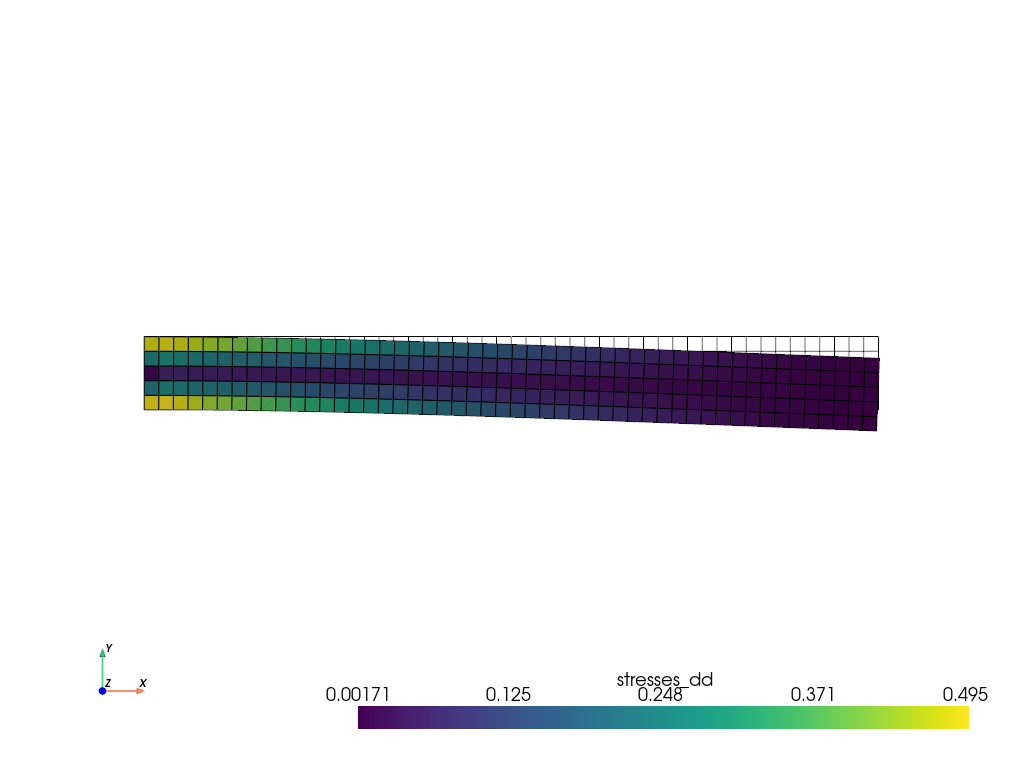

In [28]:
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_dd)] = u_dd.x.array.reshape((geometry.shape[0], 2))
grid["u_dd"] = values
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u_dd", factor=1.0)
warped.cell_data["stresses_dd"] = stresses_dd.x.array
warped.set_active_scalars("stresses_dd")
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
p.camera_position = 'xy'
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("stresses_dd.png")

In [29]:
print(warped.cell_data)

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : stresses_dd
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    stresses_dd             float64    (250,)               SCALARS


In [30]:
print(Sh.element.interpolation_points())

[[0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 1.]]


In [31]:
element = ufl.TensorElement("Quadrature",ufl.quadrilateral,2)
Q = fem.FunctionSpace(domain,element)
sig_test = fem.Function(Q)
sig_test.interpolate(fem.Expression(sigma_hooke(epsilon(std_uh)),Q.element.interpolation_points()))
print(sig_test.x.array.reshape((-1,tdim,tdim)))

RuntimeError: Cannot get interpolation points - no Basix element available. Maybe this is a mixed element?